In [1]:
from os import makedirs, path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler # StandardScaler

<h3> 視覺畫圖表函數 </h3>

In [2]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # Windows 常見字體
plt.rcParams['axes.unicode_minus'] = False  # 解決座標軸負號顯示問題

In [3]:
makedirs('feature', exist_ok=True)

In [4]:
# 使用 箱線圖 來檢查特徵中的異常值。
def visualize_outliers(data, save=False, bound_text=False):
    
    '''
    繪製箱線圖（Box Plot），可視化異常值。
    '''
    
    # 1. 提取特徵列
    plot_cols = ['temperature', 'turbidity', 'disolved_oxg', 'ph', 'ammonia', 'nitrate', 'fish_length', 'fish_weight']  # 提取指定的特徵

    # 2. 定義顏色，與特徵列對應
    colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'deeppink']

    # 3. 動態計算子圖佈局
    n_features = len(plot_cols)  # 特徵數量
    ncols = 2  # 每行顯示 3 個子圖
    nrows = (n_features + ncols - 1) // ncols  # 計算需要的行數（向上取整）

    # 4. 創建子圖
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))  # 動態設置子圖大小
    axs = axs.flatten()  # 將子圖矩陣展平成一維數組，方便索引
    fig.subplots_adjust(wspace=0.4, hspace=0.5)  # 調整子圖間距
    
    # 5. 繪製每個特徵的箱線圖
    for i, col in enumerate(plot_cols):
        axs[i].boxplot(data[col], patch_artist=True, boxprops=dict(facecolor=colors[i % len(colors)], alpha=0.6))
        axs[i].set_title(col, fontsize=12)  # 設置每個箱線圖的標題
        axs[i].set_ylabel("值", rotation=0)  # y 軸標籤
        axs[i].set_xticks([])  # 隱藏 y 軸刻度
        axs[i].set_xlabel(f"{col}", rotation=0) # x 軸標籤
        
        if bound_text:
                # 計算上下四分位數和鬍鬚的數值
            Q1 = np.percentile(data[col], 25)  # 下四分位數
            Q3 = np.percentile(data[col], 75)  # 上四分位數
            IQR = Q3 - Q1  # 四分位距
            lower_bound = Q1 - 1.5 * IQR  # 下鬍鬚
            upper_bound = Q3 + 1.5 * IQR  # 上鬍鬚
                # 標註上下邊緣值
            axs[i].text(1.1, lower_bound, f"{col} Lower: {lower_bound:.2f}", color='blue', fontsize=10, ha='left')
            axs[i].text(1.1, upper_bound, f"{col} Upper: {upper_bound:.2f}", color='red', fontsize=10, ha='left')


    # 顯示圖表
    plt.tight_layout()
    if save:
        plt.savefig('feature/IoTpond1 Features Outlier Detection.png', bbox_inches='tight') # 儲存圖表，並且自動調整圖表的邊界，去除多餘的空白區域。
    plt.show()
    

In [5]:
# 使用 分佈圖 來檢查特徵中的異常值。
def visualize_distributions(data, save=False):
    
    '''
    繪製分佈圖，可視化異常值。
    '''
    plot_cols = ['temperature', 'turbidity', 'disolved_oxg', 'ph', 'ammonia', 'nitrate', 'fish_length', 'fish_weight']  # 提取指定的特徵
    n_features = len(plot_cols)
    ncols = 2
    nrows = (n_features + ncols - 1) // ncols

    # 創建子圖
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axs = axs.flatten() # 將子圖展平成一維陣列
    fig.subplots_adjust(wspace=0.4, hspace=0.5) # 調整子圖間距

    # 遍歷每個特徵，繪製直方圖
    for i, col in enumerate(plot_cols):
        sns.histplot(data[col], kde=True, ax=axs[i], color='orange', alpha=0.5)  # 繪製直方圖和 KDE 曲線
        axs[i].tick_params(axis='x', labelsize=10)  # # 設置 x 軸刻度和標籤大小。
        axs[i].set_title(col, fontsize=12) # 設置標題。

    # 顯示圖表
    plt.tight_layout()
    if save:
        plt.savefig('feature/IoTpond1 Features Distributions.png', bbox_inches='tight') # 儲存圖表，並且自動調整圖表的邊界，去除多餘的空白區域。
    plt.show()
    

In [6]:
# 將多個特徵（列）的數據繪製成子圖，並基於提供的日期時間索引進行繪製。
def visualize_df(data, date_times, save=False): 
    '''
    將多個特徵列在子圖中進行時間序列可視化。
    '''
    # 1. 提取數據和時間索引
    df = data
    date_time = date_times
    plot_cols = df.columns # 提取列名（特徵名）

    # 2. 定義顏色，與特徵列對應
    colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'deeppink']

    # 3. 設置繪圖特徵和時間索引
    plot_features = df[plot_cols] # 選擇所有特徵列
    plot_features.index = date_time # 將日期時間設為索引，方便繪圖

    # 4. 創建子圖
    fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(15, 10)) # 4 行 2 列的子圖佈局
    fig.subplots_adjust(wspace=0.1, hspace=0.2) # 調整子圖之間的間距
    
     # 5. 遍歷每個特徵，並繪製到對應的子圖中
    for i, col in enumerate(plot_features): # 遍歷每個特徵（列名）
        row_idx = i // 2 # 確定當前特徵位於哪一行
        col_idx = i % 2  # 確定當前特徵位於哪一列
        axs[row_idx, col_idx].plot(plot_features[col], color=colors[i], label=col) # 繪製該特徵的數據
        axs[row_idx, col_idx].tick_params(axis='x', labelsize=7) # 指定顏色
        axs[row_idx, col_idx].legend() # 設置圖例為列名

    # 6. 顯示圖表
    plt.tight_layout()
    if save:
        plt.savefig('feature/IoTpond1 Features Analysis.png', bbox_inches='tight') # 儲存圖表，並且自動調整圖表的邊界，去除多餘的空白區域。
    plt.show()
    

In [7]:
# 繪製時間序列數據及其異常值（outliers）的函數。
def plot_outlier(ts, n_column, ewm_span=100, threshold=3.0, save=False):
    '''
    利用 指數加權移動平均（EWMA） 來檢測異常。
    1.) ts：需要檢測異常值的時間序列資料，應該是 pandas.Series 型態。
    2.) n_column：圖表的標題，通常是欄位名稱，用來指明是哪個特徵（feature）。
    3.) ewm_span：控制指數加權移動平均的平滑度，越高的值使平滑效果越強（默認為 100）。
    4.) threshold：異常值的檢測閾值，以標準差為單位，默認為 3.0，即數值偏離均值超過 3 個標準差會被認為是異常值。
    '''
    assert type(ts) == pd.Series # 確保 ts 是一個 pandas.Series 型態，否則會報錯。
    fig, ax = plt.subplots(figsize=(15,5)) # 建立圖表，並設置圖表大小為 15x5。
    ewm_mean = ts.ewm(span=ewm_span).mean()  # 計算時間序列的指數加權移動平均值（EWMA）。
    ewm_std = ts.ewm(span=ewm_span).std()  # 計算時間序列的指數加權標準差，用來判斷異常值。
    ax.plot(ts, label='original') # 繪製原始時間序列數據。
    ax.plot(ewm_mean, label='ewma') # 繪製指數加權移動平均線，提供平滑的數據趨勢。

    # plot data which deviate from range during mean ±  3 * std as outlier 
    ax.fill_between(ts.index,
                    ewm_mean - ewm_std * threshold,
                    ewm_mean + ewm_std * threshold,
                    alpha=0.2) # 填充一個區域，範圍為平均值加減 3 倍標準差（可以根據 threshold 調整），用來表示「正常區域」。位於此區域外的數據將視為異常值。
    outlier = ts[(ts - ewm_mean).abs() > ewm_std * threshold] # 篩選出超出正常區域的異常值。
    ax.scatter(outlier.index, outlier, label='outlier') # 使用散點圖標記異常值的位置。
    ax.legend() # 添加圖例，標示出原始數據、移動平均線和異常值。
    plt.title(n_column) # 設置圖表標題為指定的欄位名稱（n_column）。
    if save:
        plt.savefig(f'feature/{n_column}.png') # 儲存圖表
    plt.show()


<h3> Start IoTPond1 </h3>

In [8]:
# 讀取數據
df = pd.read_csv('IoTpond1.csv')
df

,created_at,entry_id,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,population,fish_length,fish_weight
0,2021-06-19 00:00:05 CET,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
1,2021-06-19 00:01:02 CET,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2,2021-06-19 00:01:22 CET,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
3,2021-06-19 00:01:44 CET,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
4,2021-06-19 00:02:07 CET,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91
...,...,...,...,...,...,...,...,...,...,...,...
83121,2021-10-13 02:48:31 CET,247201,26.5625,100,0.441,2.56412,5.91282,946,50,33.45,318.64
83122,2021-10-13 03:17:36 CET,247273,26.5625,100,1.020,2.67760,4.21414,985,50,33.45,318.64
83123,2021-10-13 03:46:49 CET,247336,26.5000,100,0.852,2.45063,8.18873,963,50,33.45,318.64
83124,2021-10-13 04:13:23 CET,247402,26.3750,100,4.850,2.41885,10.62411,944,50,33.45,318.64


<p> Note: 欄位代表的意思 </p>
<ol>
    <li>created_at:資料記錄的時間戳，表示數據被收集的時間。</li>
    <li>entry_id:每條數據記錄的唯一標識符，用於區分不同的數據記錄。不直接影響分析。</li>
    <li>temperature:水溫，表示魚塘的水溫（攝氏）。</li>
    <li>turbidity:渾濁度，表示水的透明程度或清澈程度。</li>
    <li>disolved_oxg:溶解氧濃度，表示水中溶解氧的含量（mg/L）。</li>
    <li>ph:水的酸鹼度。</li>
    <li>ammonia:氨濃度，表示水中氨的濃度。</li>
    <li>nitrate:硝酸鹽濃度，表示水中的硝酸鹽含量。</li>
    <li>population:魚塘中的魚類數量。</li>
    <li>fish_length:魚的平均長度（單位：厘米）。</li>
    <li>fish_weight:魚的平均重量（單位：克）。</li>
</ol>

In [9]:
df['entry_id'].nunique()
df['created_at'].nunique()

83126

In [10]:
# 將created_at設為index
df["created_at"] = pd.to_datetime(df["created_at"].str.replace(" CET", ""), format="%Y-%m-%d %H:%M:%S") # %Z
df = df.sort_values('created_at')
df.set_index('created_at', inplace=True)
df

,entry_id,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,population,fish_length,fish_weight
created_at,,,,,,,,,,
2021-06-19 00:00:05,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:01:02,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2021-06-19 00:01:22,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
2021-06-19 00:01:44,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:02:07,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91
...,...,...,...,...,...,...,...,...,...,...
2021-10-13 02:48:31,247201,26.5625,100,0.441,2.56412,5.91282,946,50,33.45,318.64
2021-10-13 03:17:36,247273,26.5625,100,1.020,2.67760,4.21414,985,50,33.45,318.64
2021-10-13 03:46:49,247336,26.5000,100,0.852,2.45063,8.18873,963,50,33.45,318.64


In [11]:
# Dropping the unnecessary columns
columns_to_drop = ['entry_id', 'population']  
df = df.drop(columns=columns_to_drop)
df

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
created_at,,,,,,,,
2021-06-19 00:00:05,24.8750,100,4.505,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:01:02,24.9375,100,6.601,8.43818,0.45842,194,7.11,2.91
2021-06-19 00:01:22,24.8750,100,15.797,8.42457,0.45842,192,7.11,2.91
2021-06-19 00:01:44,24.9375,100,5.046,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:02:07,24.9375,100,38.407,8.40641,0.45842,192,7.11,2.91
...,...,...,...,...,...,...,...,...
2021-10-13 02:48:31,26.5625,100,0.441,2.56412,5.91282,946,33.45,318.64
2021-10-13 03:17:36,26.5625,100,1.020,2.67760,4.21414,985,33.45,318.64
2021-10-13 03:46:49,26.5000,100,0.852,2.45063,8.18873,963,33.45,318.64


<p> 查看是否有缺失值。 </p>

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83126 entries, 2021-06-19 00:00:05 to 2021-10-13 04:14:22
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temperature   83126 non-null  float64
 1   turbidity     83126 non-null  int64  
 2   disolved_oxg  83126 non-null  float64
 3   ph            83126 non-null  float64
 4   ammonia       83074 non-null  float64
 5   nitrate       83126 non-null  int64  
 6   fish_length   83124 non-null  float64
 7   fish_weight   83124 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 5.7 MB


In [13]:
# checking null values in our dataset
df.isna().sum()

temperature      0
turbidity        0
disolved_oxg     0
ph               0
ammonia         52
nitrate          0
fish_length      2
fish_weight      2
dtype: int64

<p> ammonia、fish_length、fish_weight 皆存在缺失值！ </p>

<h4> 使用 箱線圖 或 分佈圖 來檢查特徵中的異常值。 </h4>

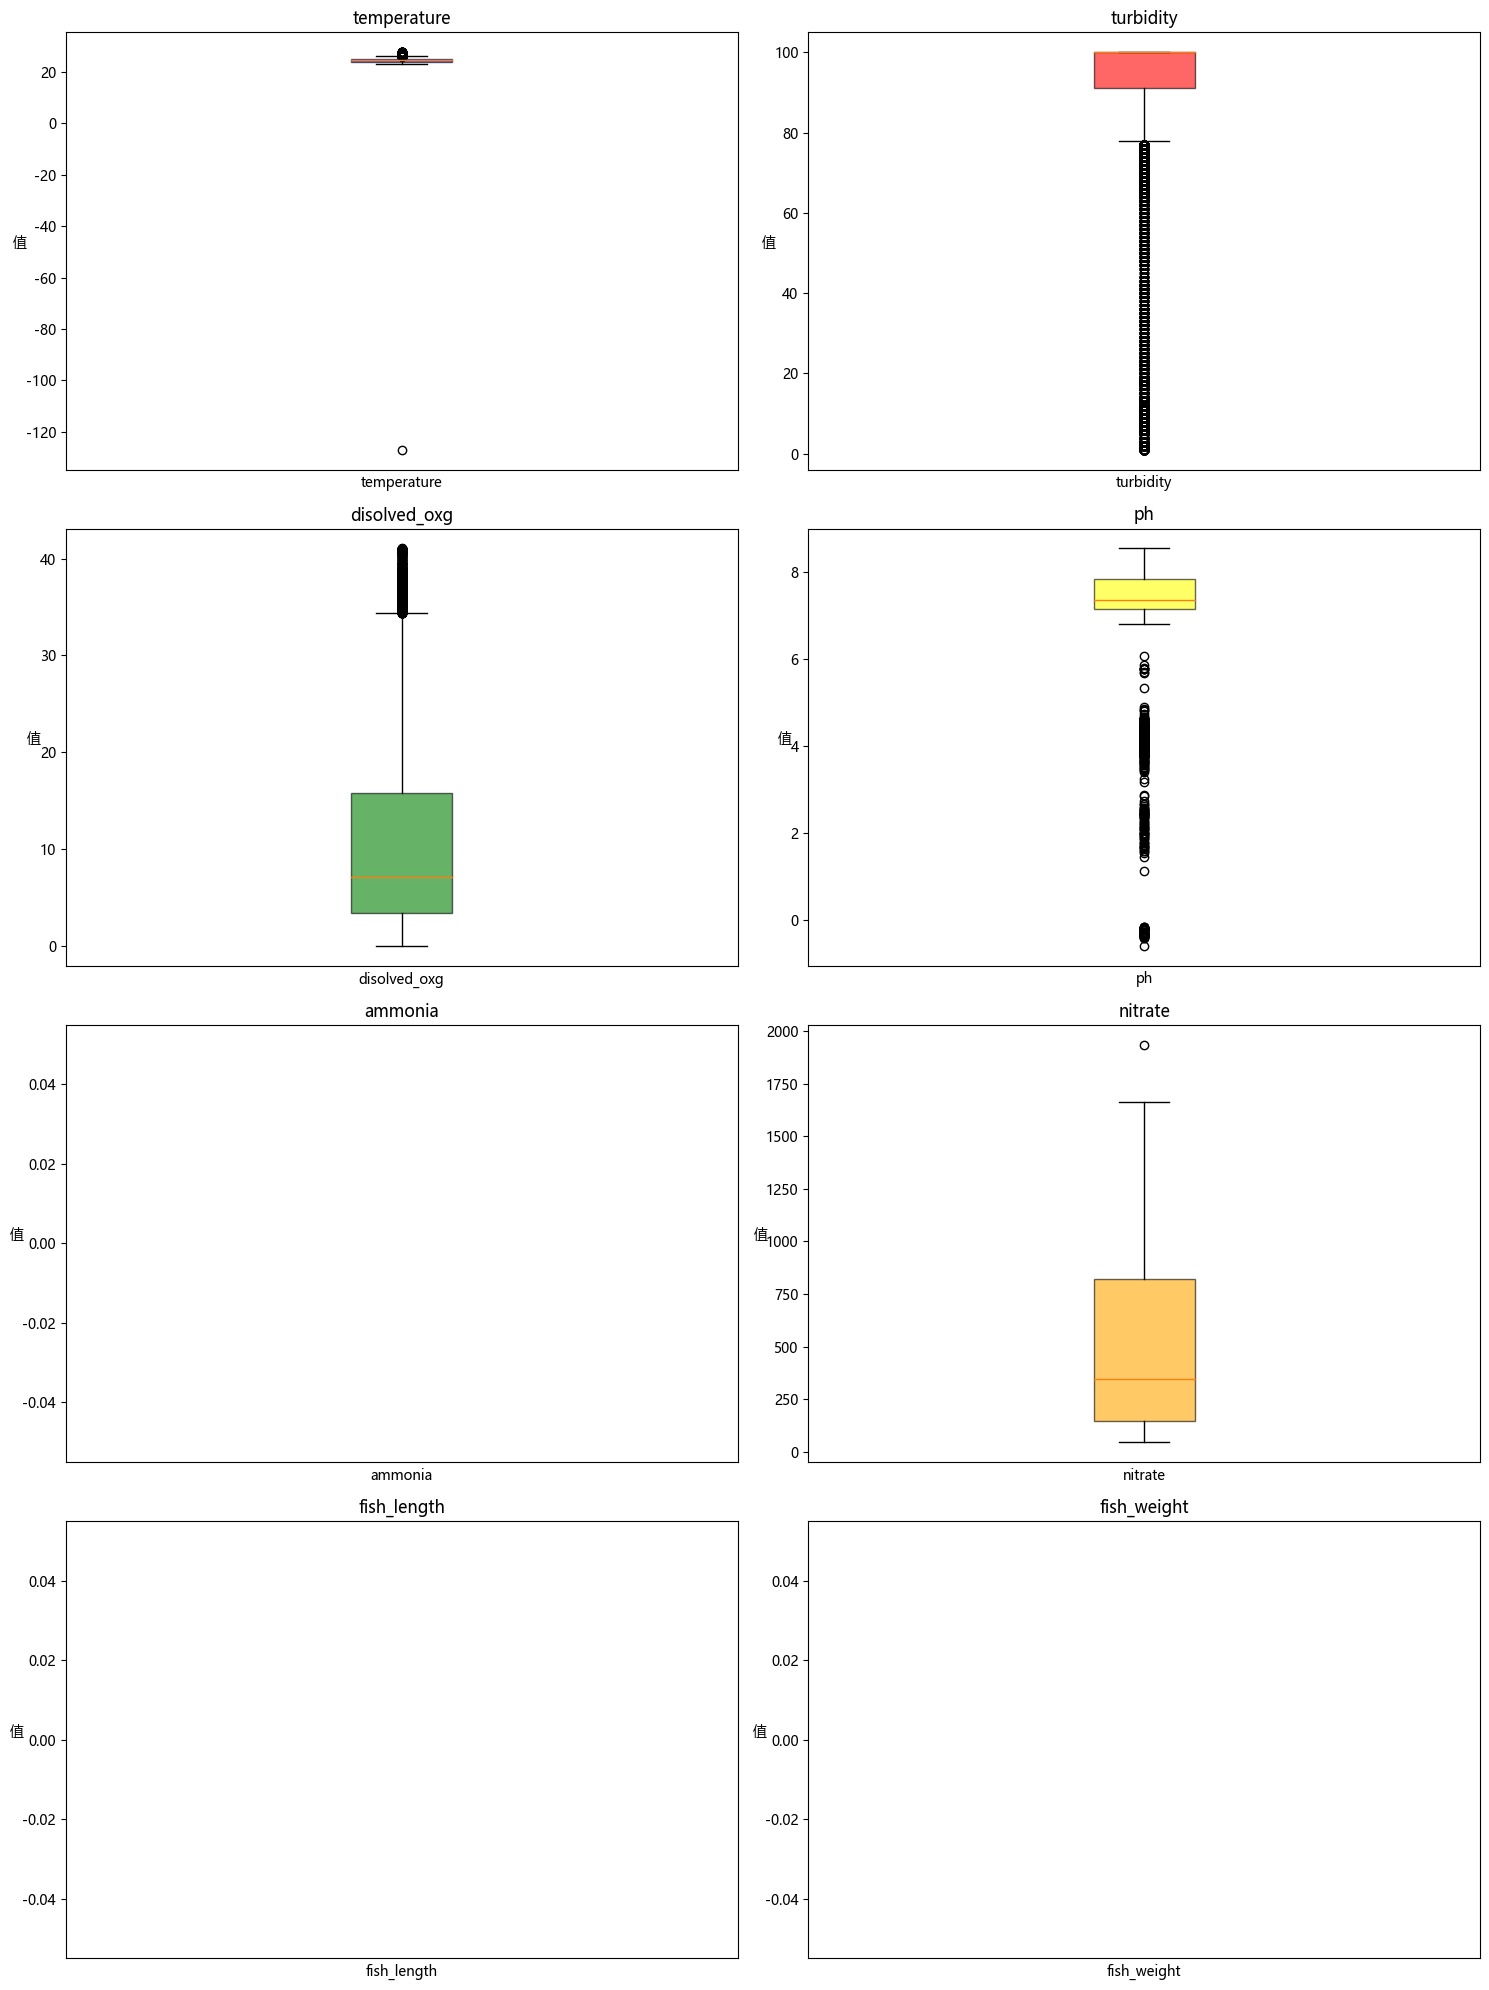

In [14]:
# 使用 箱線圖 來檢查特徵中的異常值。
visualize_outliers(df)
# visualize_outliers_and_distributions(df) # 使用 分佈圖 來檢查特徵中的異常值。 # MemoryError

<ol>
    <li> ammonia、fish_length 和 fish_weight 包含缺失值，所以箱線圖暫且無法繪製。</li>
    <li> 且temperature有一筆異常值。 </li>
</ol>

In [15]:
#敘述統計
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature,83126.0,2.457338e+01,8.615318e-01,-127.00000,24.12500,24.56250,24.93750,2.775000e+01
turbidity,83126.0,8.749016e+01,2.585937e+01,1.00000,91.00000,100.00000,100.00000,1.000000e+02
disolved_oxg,83126.0,1.239025e+01,1.251825e+01,0.00700,3.44000,7.13300,15.81900,4.104600e+01
ph,83126.0,7.518329e+00,5.347873e-01,-0.58627,7.15352,7.35779,7.83898,8.551670e+00
ammonia,83074.0,2.030817e+08,7.866231e+09,0.00677,0.45842,0.61166,15.58803,4.270000e+11
nitrate,83126.0,4.582944e+02,3.383132e+02,45.00000,146.00000,347.00000,823.00000,1.936000e+03
fish_length,83124.0,1.641469e+01,5.272244e+00,7.11000,11.79000,18.08000,21.00000,3.345000e+01
fish_weight,83124.0,4.456847e+01,3.321549e+01,2.91000,14.19000,54.70000,67.52000,3.186400e+02


<p> 有異常數據需要處理！ </p>

<h3> 處理缺失值&異常值 </h3>

In [16]:
# 刪除 fish_weight 欄位中有缺失值的行
df = df.dropna(subset=['fish_weight'])
df

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
created_at,,,,,,,,
2021-06-19 00:00:05,24.8750,100,4.505,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:01:02,24.9375,100,6.601,8.43818,0.45842,194,7.11,2.91
2021-06-19 00:01:22,24.8750,100,15.797,8.42457,0.45842,192,7.11,2.91
2021-06-19 00:01:44,24.9375,100,5.046,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:02:07,24.9375,100,38.407,8.40641,0.45842,192,7.11,2.91
...,...,...,...,...,...,...,...,...
2021-10-13 02:48:31,26.5625,100,0.441,2.56412,5.91282,946,33.45,318.64
2021-10-13 03:17:36,26.5625,100,1.020,2.67760,4.21414,985,33.45,318.64
2021-10-13 03:46:49,26.5000,100,0.852,2.45063,8.18873,963,33.45,318.64


<p> temperature 水溫 </p>

In [17]:
# 有筆溫度為-127，不合理，刪除該筆資料。刪除不合理的溫度(異常值)。
df = df[df['temperature'] != -127]
df

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
created_at,,,,,,,,
2021-06-19 00:00:05,24.8750,100,4.505,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:01:02,24.9375,100,6.601,8.43818,0.45842,194,7.11,2.91
2021-06-19 00:01:22,24.8750,100,15.797,8.42457,0.45842,192,7.11,2.91
2021-06-19 00:01:44,24.9375,100,5.046,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:02:07,24.9375,100,38.407,8.40641,0.45842,192,7.11,2.91
...,...,...,...,...,...,...,...,...
2021-10-13 02:48:31,26.5625,100,0.441,2.56412,5.91282,946,33.45,318.64
2021-10-13 03:17:36,26.5625,100,1.020,2.67760,4.21414,985,33.45,318.64
2021-10-13 03:46:49,26.5000,100,0.852,2.45063,8.18873,963,33.45,318.64


<p> Nitrate 硝酸鹽濃度 </p>

In [18]:
# 有筆 nitrate硝酸鹽濃度 為1936，從箱型圖上看為異常值，因此刪除該筆資料。
df = df[df['nitrate'] != 1936]
df

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
created_at,,,,,,,,
2021-06-19 00:00:05,24.8750,100,4.505,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:01:02,24.9375,100,6.601,8.43818,0.45842,194,7.11,2.91
2021-06-19 00:01:22,24.8750,100,15.797,8.42457,0.45842,192,7.11,2.91
2021-06-19 00:01:44,24.9375,100,5.046,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:02:07,24.9375,100,38.407,8.40641,0.45842,192,7.11,2.91
...,...,...,...,...,...,...,...,...
2021-10-13 02:48:31,26.5625,100,0.441,2.56412,5.91282,946,33.45,318.64
2021-10-13 03:17:36,26.5625,100,1.020,2.67760,4.21414,985,33.45,318.64
2021-10-13 03:46:49,26.5000,100,0.852,2.45063,8.18873,963,33.45,318.64


<p> Fish Weight </p>

<ol> Note: 針對目標變數（Fish Weight）去除異常值
    <li> 因為異常值的存在可能會對模型的學習過程產生負面影響，因此針對目標變數（Fish Weight）去除異常值。直接針對目標變數進行優化。 </li>
    <li> 簡化處理，避免過度刪除可能有用的數據點。 </li>
</ol>

In [19]:
# 對目標變數(Fish Weight)找出異常值並篩除。
Q1 = df['fish_weight'].quantile(0.25) # 第一四分位數
Q3 = df['fish_weight'].quantile(0.75) # 第三四分位數
IQR = Q3 - Q1

# 計算上下界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 找出異常值
outliers = df[(df['fish_weight'] < lower_bound) | (df['fish_weight'] > upper_bound)]
outliers = outliers.sort_values('fish_weight')
outliers

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
created_at,,,,,,,,
2021-09-04 00:02:11,23.7500,100,3.097,6.88569,5.69339,1122,25.85,148.65
2021-09-04 16:48:47,24.1875,100,0.152,6.84937,2.46591,1086,25.85,148.65
2021-09-04 16:51:00,24.1875,100,0.895,6.84937,1.75114,1041,25.85,148.65
2021-09-04 17:05:22,24.1875,100,2.527,6.85391,1.87227,1106,25.85,148.65
2021-09-04 17:20:08,24.1875,100,1.132,6.85391,1.39611,1127,25.85,148.65
...,...,...,...,...,...,...,...,...
2021-10-13 00:56:35,26.8125,100,0.197,2.62313,6.44293,1015,33.45,318.64
2021-10-13 00:18:41,26.8125,100,0.746,2.50057,5.61209,1136,33.45,318.64
2021-10-13 04:13:23,26.3750,100,4.850,2.41885,10.62411,944,33.45,318.64


In [20]:
df = df[(df['fish_weight'] >= lower_bound) & (df['fish_weight'] <= upper_bound)]
df

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
created_at,,,,,,,,
2021-06-19 00:00:05,24.8750,100,4.505,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:01:02,24.9375,100,6.601,8.43818,0.45842,194,7.11,2.91
2021-06-19 00:01:22,24.8750,100,15.797,8.42457,0.45842,192,7.11,2.91
2021-06-19 00:01:44,24.9375,100,5.046,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:02:07,24.9375,100,38.407,8.40641,0.45842,192,7.11,2.91
...,...,...,...,...,...,...,...,...
2021-09-03 23:36:09,23.7500,100,0.580,6.89477,6.68979,1114,25.60,145.30
2021-09-03 23:43:00,23.7500,100,0.812,6.89023,5.82565,1131,25.60,145.30
2021-09-03 23:45:12,23.8125,100,2.088,6.88569,7.19917,1104,25.60,145.30


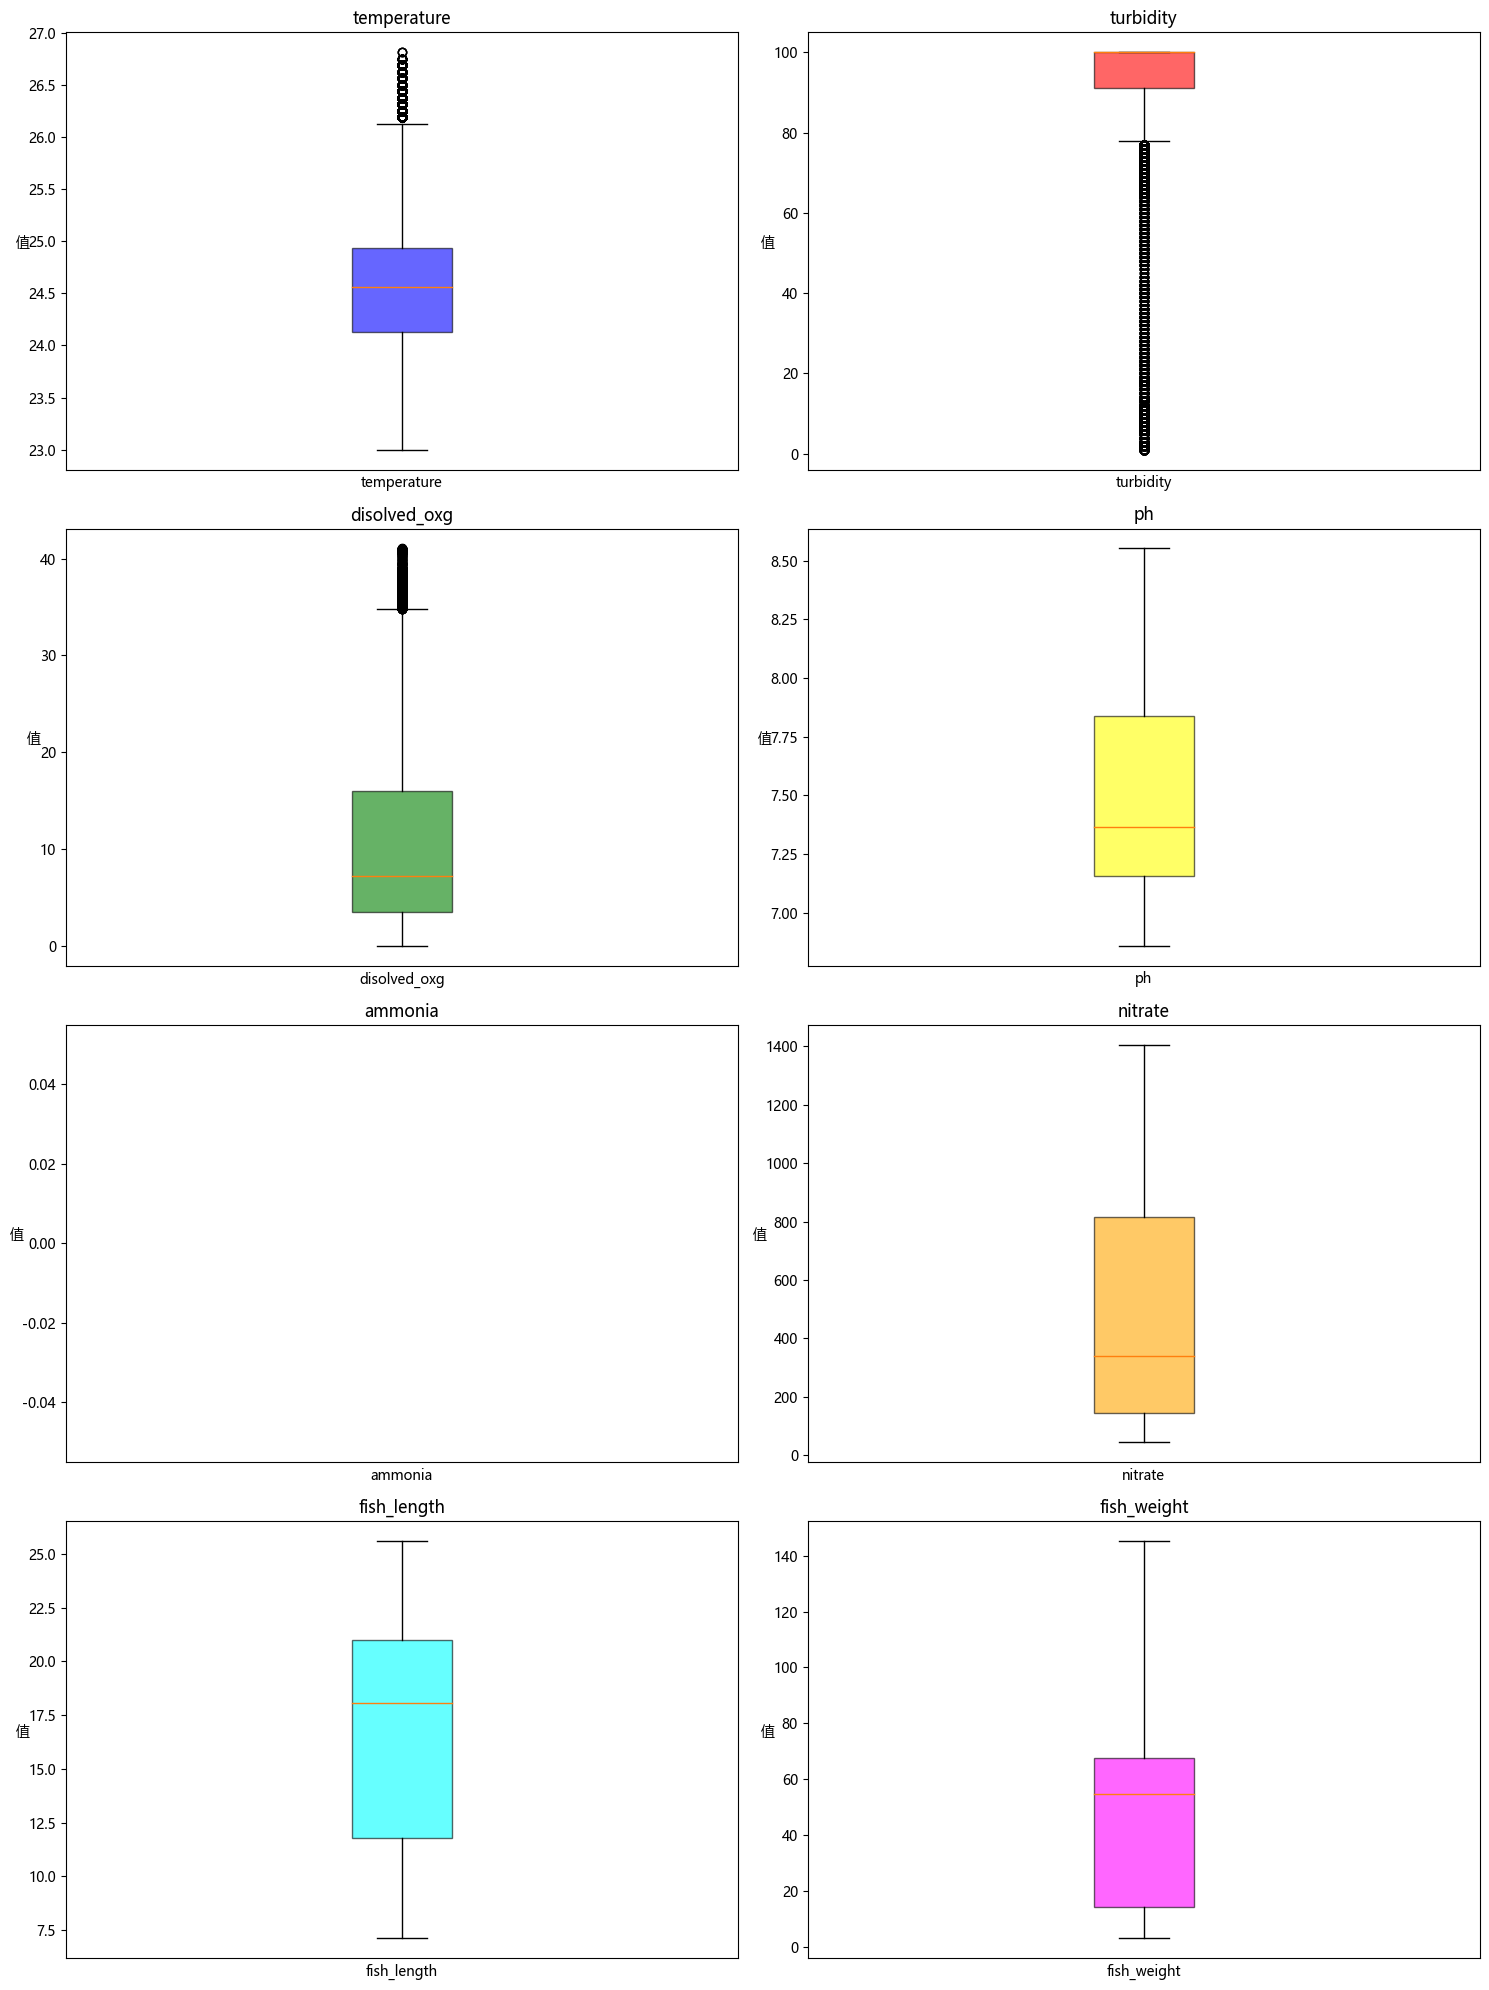

In [21]:
visualize_outliers(df) # bound_text=True

In [22]:
# 填補其他欄位中有缺失值的行
for col in df.columns:
    
    # 1. 使用平均數(mean)來填補缺失值，避免直接刪除缺失值而損失過多數據。
    # 但是平均值可能無法反映數據的真實分佈。因此改用插值法（Interpolation）。
    # col_mean = df[col].mean()
    # df[col] = df[col].fillna(col_mean)

    # 2. 插值法的優點與
    # 1.) 能根據數據趨勢進行填補，避免平均值或中位數填補可能導致數據分佈失真的問題。
    # 2.) 對於連續的時間序列或數值型數據尤為有效。
    if df[col].isnull().any():  # 檢查列中是否有缺失值
        df[col] = df[col].interpolate(method='linear', limit_direction='forward', axis=0) # 指定插值方式為線性插值。

C:\Users\HoChePing\AppData\Local\Temp\ipykernel_56392\59365643.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].interpolate(method='linear', limit_direction='forward', axis=0) # 指定插值方式為線性插值。


<p> 對數據進行修正（Data Correction），處理數據中的異常值，將不合理的數據限制在一個合理的範圍內，避免極端值對分析或模型訓練造成負面影響。 </p>

In [23]:
#correcting data
df['temperature'].loc[df['temperature'] < 20] = 20 # 將溫度低於 20 的值修正為 20，避免溫度過低可能導致分析錯誤。
df['ph'].loc[df['ph'] > 12] = 12  # 將 pH 值高於 12 的值修正為 12
df['ph'].loc[df['ph'] < 5] = 5  # 將 pH 值低於 5 的值修正為 5
df['ammonia'].loc[df['ammonia'] > 10] = 10 # 將氨濃度大於 10 的值修正為 10
df['nitrate'].loc[df['nitrate'] > 2000] = 2000 # 將硝酸鹽濃度大於 2000 的值修正為 2000

df

C:\Users\HoChePing\AppData\Local\Temp\ipykernel_56392\1711671562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temperature'].loc[df['temperature'] < 20] = 20 # 將溫度低於 20 的值修正為 20，避免溫度過低可能導致分析錯誤。
C:\Users\HoChePing\AppData\Local\Temp\ipykernel_56392\1711671562.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ph'].loc[df['ph'] > 12] = 12  # 將 pH 值高於 12 的值修正為 12
C:\Users\HoChePing\AppData\Local\Temp\ipykernel_56392\1711671562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
created_at,,,,,,,,
2021-06-19 00:00:05,24.8750,100,4.505,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:01:02,24.9375,100,6.601,8.43818,0.45842,194,7.11,2.91
2021-06-19 00:01:22,24.8750,100,15.797,8.42457,0.45842,192,7.11,2.91
2021-06-19 00:01:44,24.9375,100,5.046,8.43365,0.45842,193,7.11,2.91
2021-06-19 00:02:07,24.9375,100,38.407,8.40641,0.45842,192,7.11,2.91
...,...,...,...,...,...,...,...,...
2021-09-03 23:36:09,23.7500,100,0.580,6.89477,6.68979,1114,25.60,145.30
2021-09-03 23:43:00,23.7500,100,0.812,6.89023,5.82565,1131,25.60,145.30
2021-09-03 23:45:12,23.8125,100,2.088,6.88569,7.19917,1104,25.60,145.30


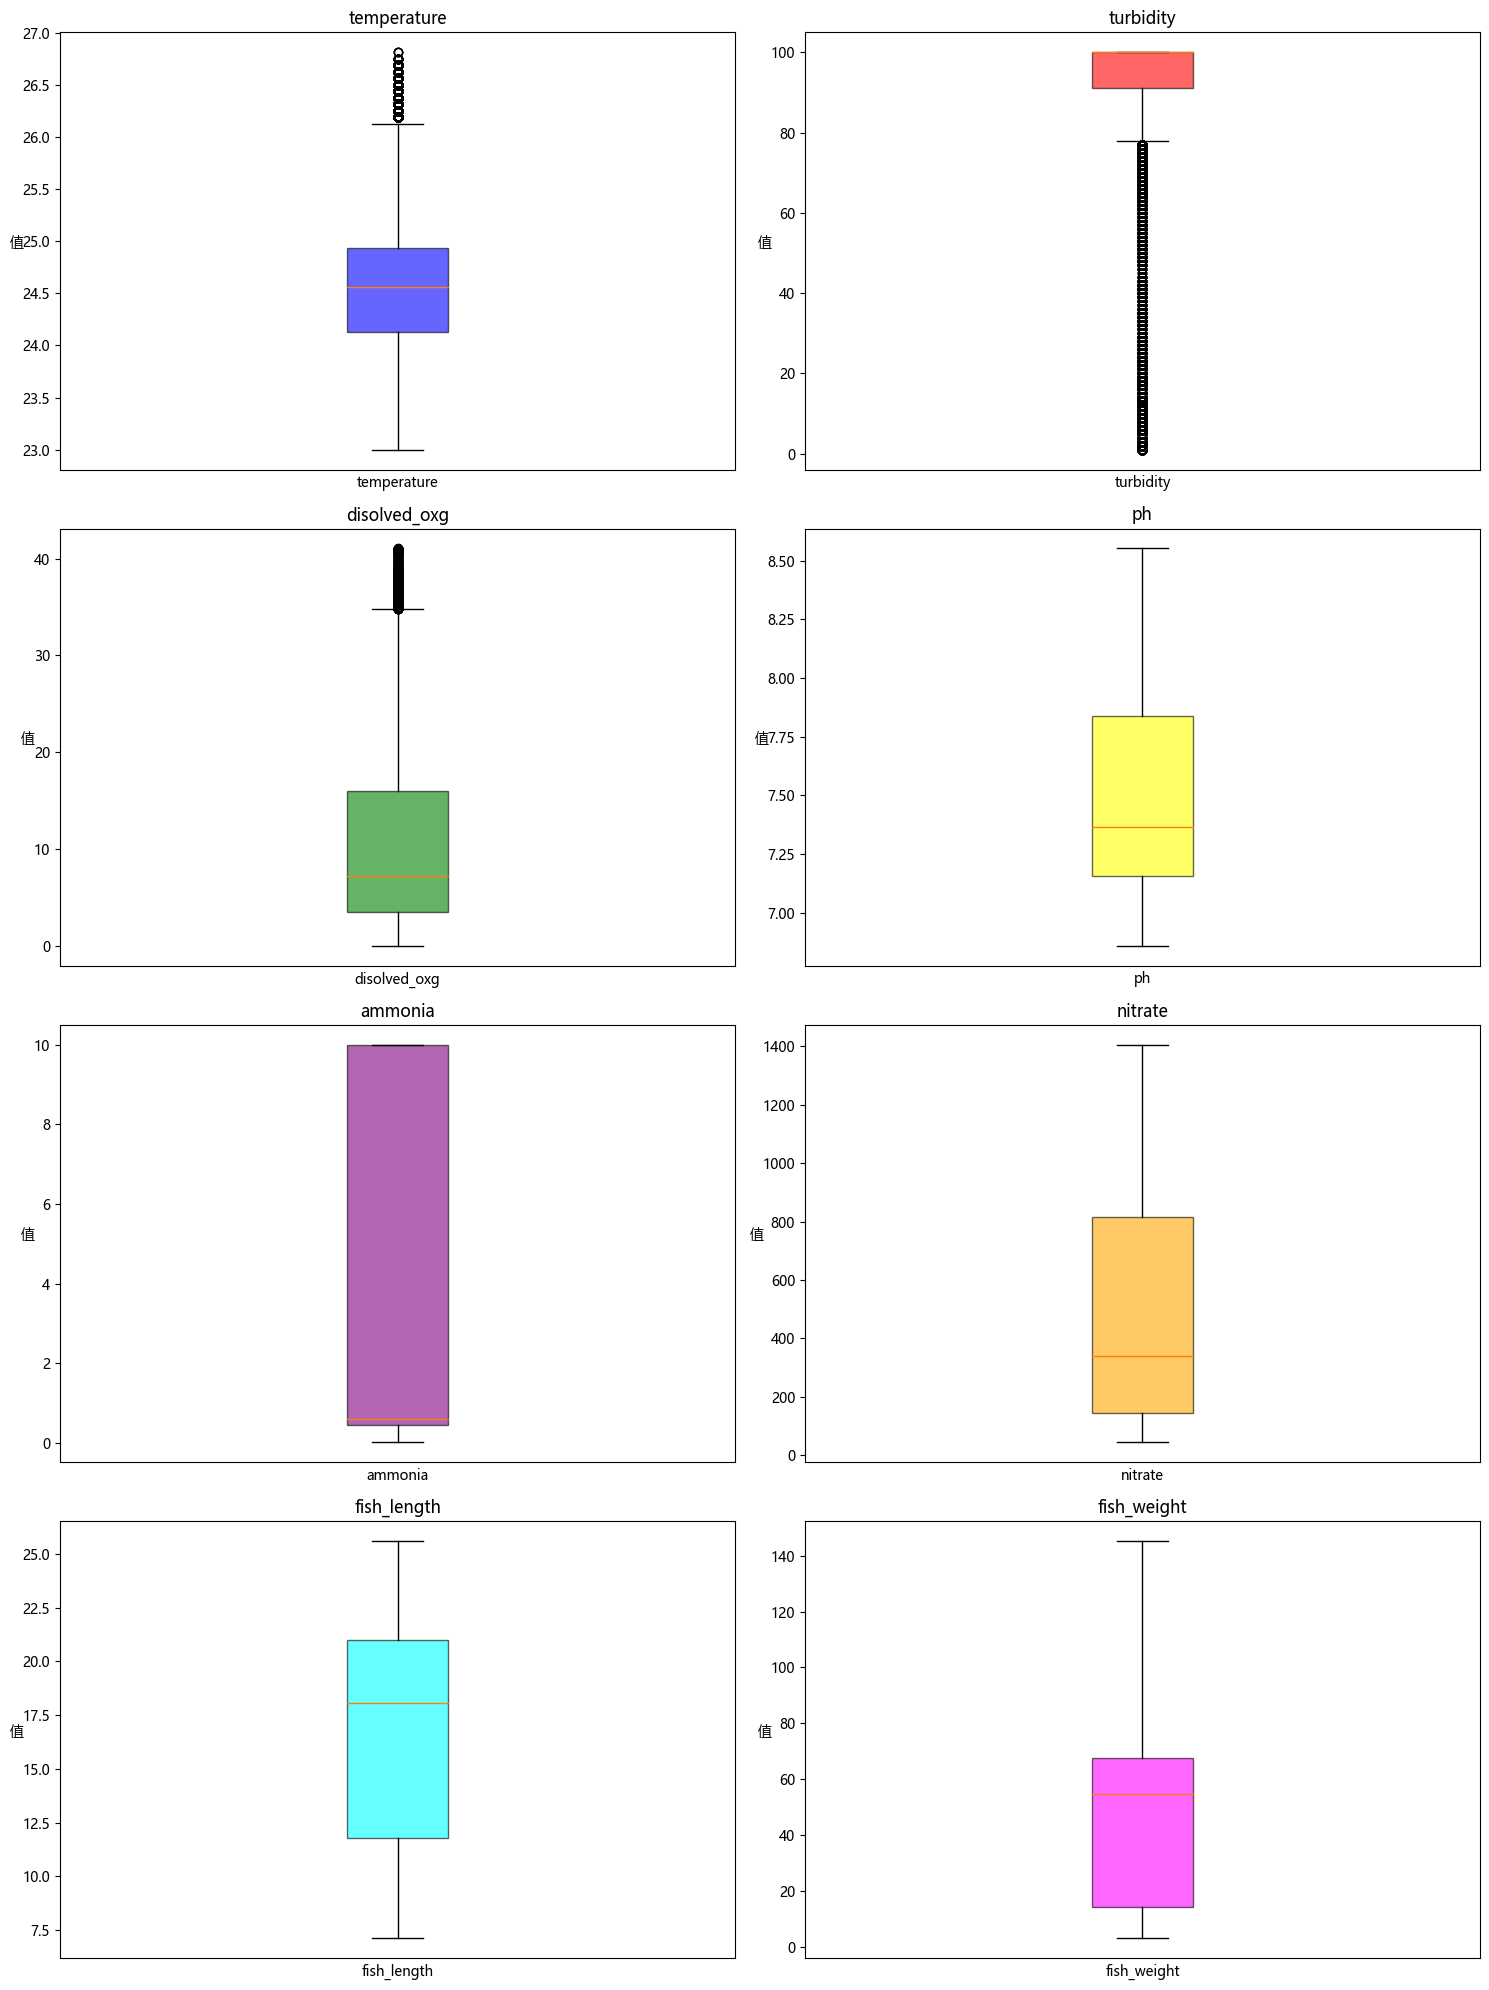

In [24]:
visualize_outliers(df)

<p> 再次檢查是否有缺失值。 </p>

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82375 entries, 2021-06-19 00:00:05 to 2021-09-03 23:53:23
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temperature   82375 non-null  float64
 1   turbidity     82375 non-null  int64  
 2   disolved_oxg  82375 non-null  float64
 3   ph            82375 non-null  float64
 4   ammonia       82375 non-null  float64
 5   nitrate       82375 non-null  int64  
 6   fish_length   82375 non-null  float64
 7   fish_weight   82375 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 5.7 MB


In [26]:
# checking null values in our dataset
df.isna().sum()

temperature     0
turbidity       0
disolved_oxg    0
ph              0
ammonia         0
nitrate         0
fish_length     0
fish_weight     0
dtype: int64

<h3 style='color:blue'> 下採樣（aggregating data）與聚合 </h3>

<ol> Note: 為什麼要使用下採樣？
    <li> 研究方向是水樣品質與魚的重量和長度的關係，而魚的重量和長度的變化通常是隨著時間逐漸累積的。它可能不會受到幾秒鐘內水質變化的影響，而是更可能受到數小時或數天內的水質趨勢影響。 </li>
    <li> 每 5 秒鐘記錄一次，數據非常密集，可能導致計算資源不足，且模型可能無法有效處理這麼大的窗口。 </li>
    <li> 為了處理頻繁的記錄，可以對數據進行下採樣（aggregating data），例如每 1 分鐘取一次平均值或特徵值，從而降低數據密度。 </li>
    <li> 下採樣數據 是處理高頻數據的關鍵步驟，可顯著減少計算負擔。 </li>
</ol>

<p style='color:purple'> 備註：原本資料集是以每5秒鐘記錄水樣品質( The datasets are generated automatically at 5 seconds intervals using the following water quality sensors driven by the ESP 32 microcontroller) </p>

<ol> Note: 先處理異常值與缺失值，再進行下採樣的優點
    <li> 特徵值中的極端值可能拉高或拉低平均值，從而影響後續的分析。 </li>
    <li> 遇到異常值或缺失值時，直接下採樣可能導致聚合結果偏離真實數據特徵。反過來說，先處理異常值（如剪裁到合理範圍）可以提高聚合的準確性。 </li>
    <li> 可以更精確地補值或修正異常值，然後進行聚合。 </li>
    <li> 在原始數據上處理異常值和缺失值，可以根據具體情況選擇替換策略，而不被聚合的結果約束。 </li>
</ol>

In [27]:
# df[::20] # 看是否需要跳號

↑ df[::20] # 看是否需要跳號

<ol> 不合理！
    <li> 如果數據的時間分佈並不均勻，直接跳號可能導致數據失去代表性。 </li>
    <li> 這種方式忽略了時間窗口的特性，可能導致丟失重要的信息。 </li>
</ol>

In [28]:
# 將數據從 每5秒 下採樣為 每分鐘（取平均值）
df = df.resample('1Min').mean() # 每分鐘聚合數據

# 空值是由於聚合後的時間窗口內完全沒有數據，因此可以適用刪除空值。
df.dropna(inplace=True) # 這些空值是由於聚合期間完全沒有數據導致的，刪除這些空值是合理的。且不會對模型訓練提供任何有用的資訊。
df

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
created_at,,,,,,,,
2021-06-19 00:00:00,24.875000,100.0,4.505000,8.433650,0.45842,193.000000,7.11,2.91
2021-06-19 00:01:00,24.916667,100.0,9.148000,8.432133,0.45842,193.000000,7.11,2.91
2021-06-19 00:02:00,24.916667,100.0,15.033333,8.421540,0.45842,193.000000,7.11,2.91
2021-06-19 00:03:00,24.916667,100.0,8.311000,8.430623,0.45842,192.333333,7.11,2.91
2021-06-19 00:04:00,24.875000,100.0,6.964000,8.483580,0.45842,191.000000,7.11,2.91
...,...,...,...,...,...,...,...,...
2021-09-03 23:36:00,23.750000,100.0,0.580000,6.894770,6.68979,1114.000000,25.60,145.30
2021-09-03 23:43:00,23.750000,100.0,0.812000,6.890230,5.82565,1131.000000,25.60,145.30
2021-09-03 23:45:00,23.812500,100.0,2.088000,6.885690,7.19917,1104.000000,25.60,145.30


In [29]:
# 檢查是否有成功填補缺失值或異常值。
df.to_csv('IoTPond1 test.csv')

<h3> 畫出視覺化數據 </h3>

<p> 查看統計資料 </p>

In [30]:
#敘述統計
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature,41726.0,24.552819,0.658914,23.03125,24.12500,24.56250,24.93750,26.770833
turbidity,41726.0,88.357165,25.437361,1.00000,92.00000,100.00000,100.00000,100.000000
disolved_oxg,41726.0,11.846832,11.873278,0.00800,3.70550,7.05450,14.57100,40.993000
ph,41726.0,7.525714,0.427224,6.85845,7.16713,7.38957,7.81959,8.501740
ammonia,41726.0,4.048733,4.363332,0.01662,0.45842,0.80149,10.00000,10.000000
nitrate,41726.0,442.170349,329.834035,61.00000,149.00000,332.00000,802.00000,1406.000000
fish_length,41726.0,16.497685,5.026756,7.11000,11.79000,18.03000,21.00000,25.600000
fish_weight,41726.0,44.201675,28.629744,2.91000,14.19000,50.04000,67.52000,145.300000


<p> 儲存可視化數據圖表 </p>

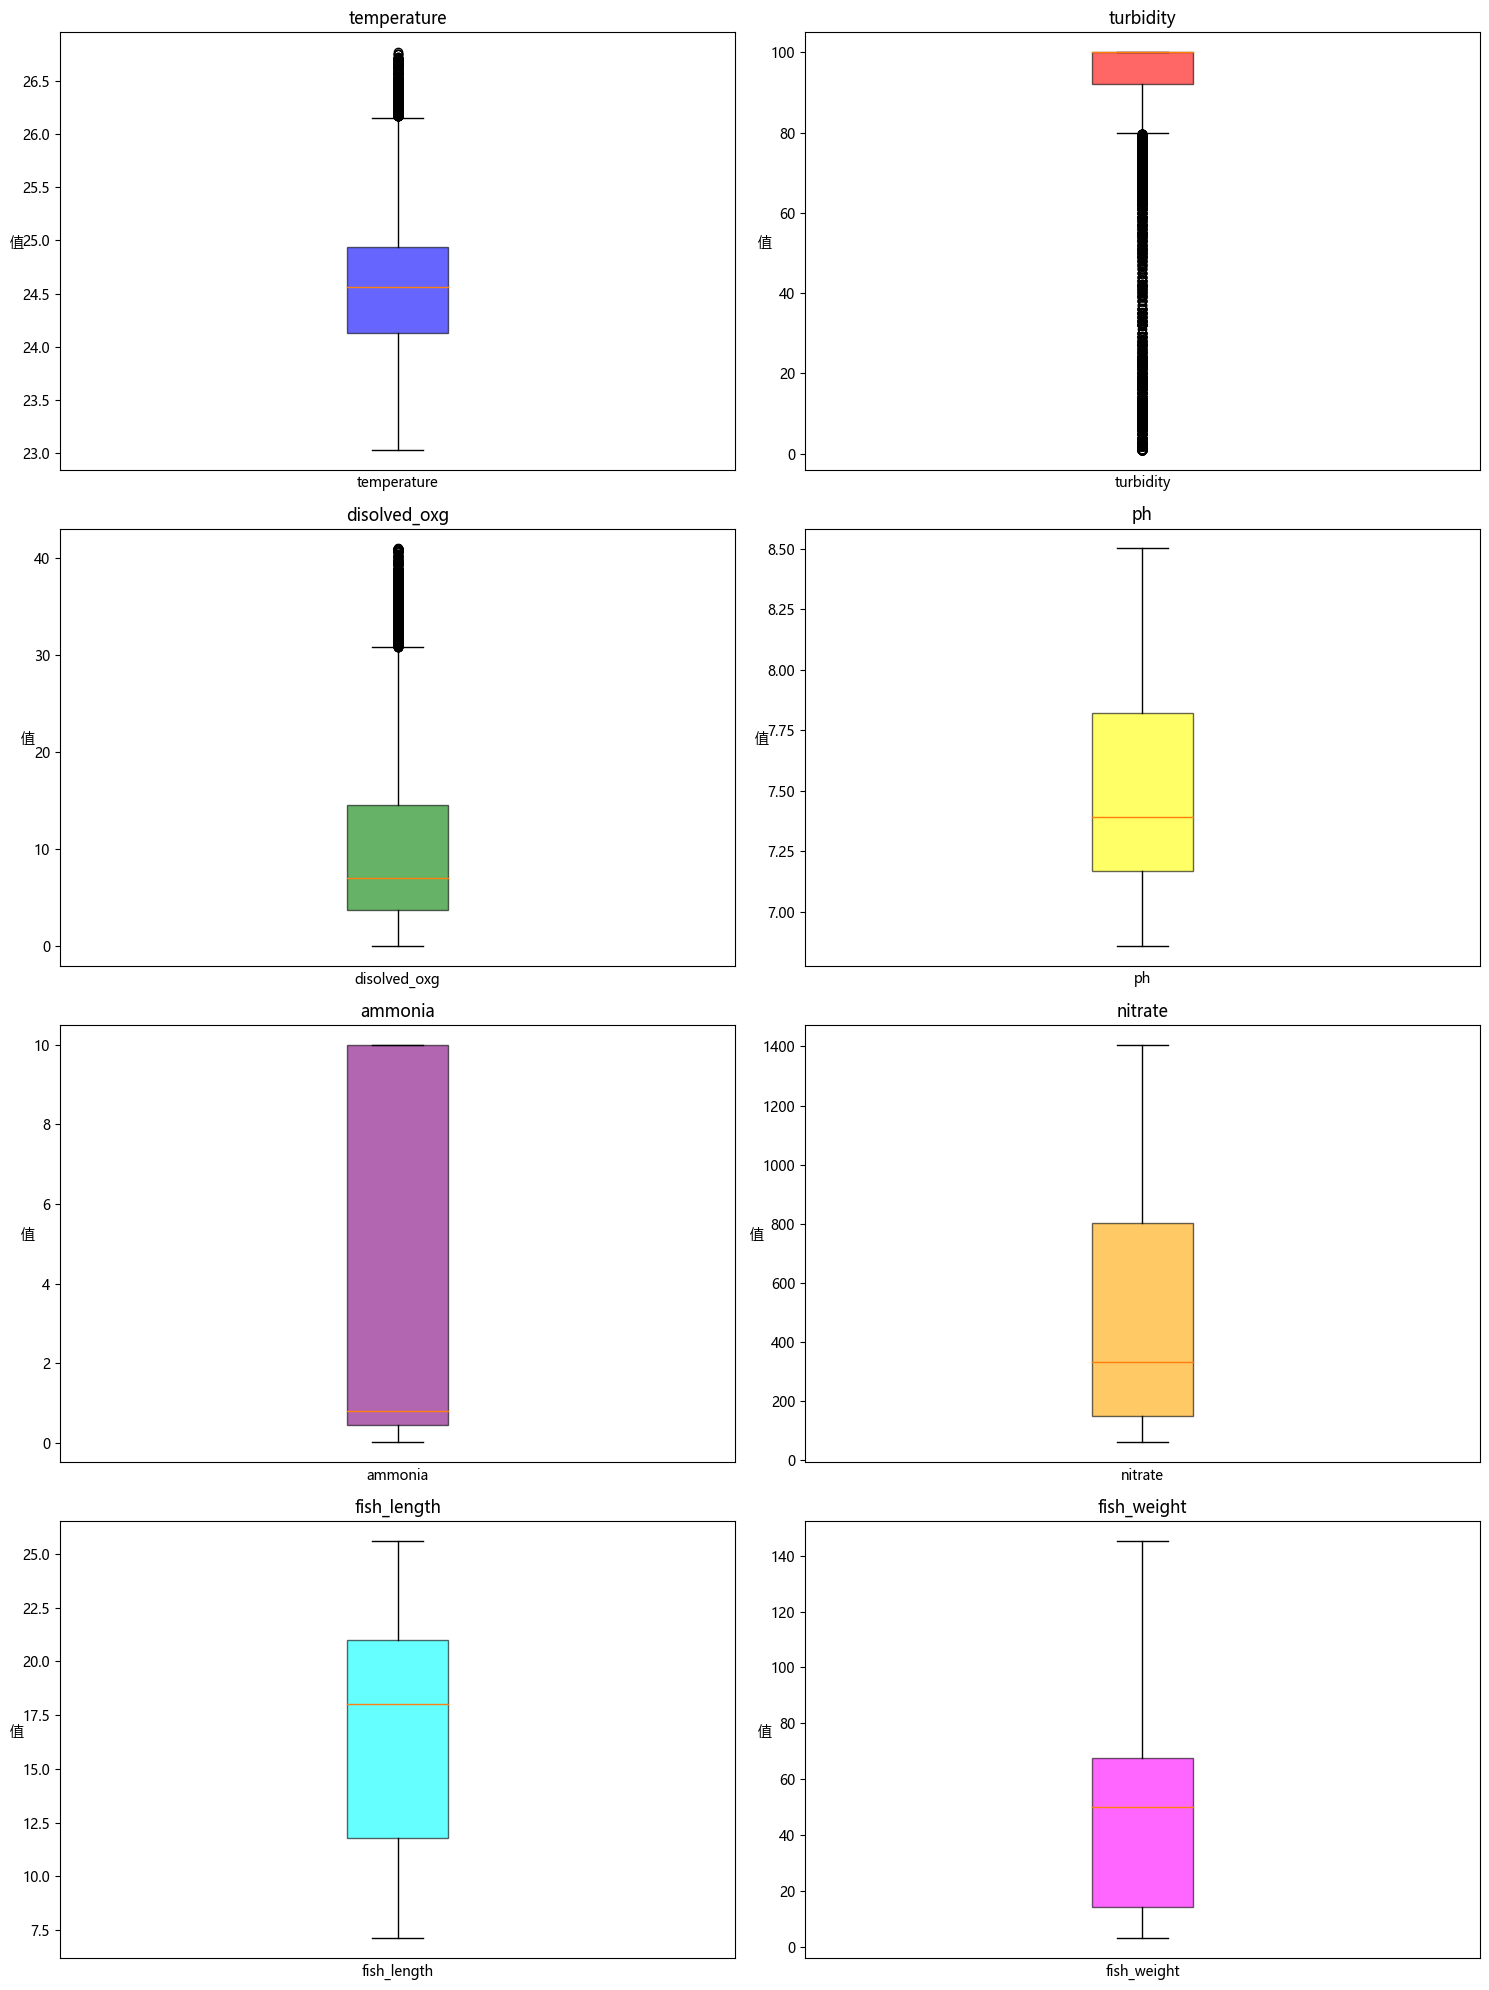

In [31]:
# 使用 箱線圖 來檢查特徵中的異常值。
visualize_outliers(df, save=True) # bound_text=True

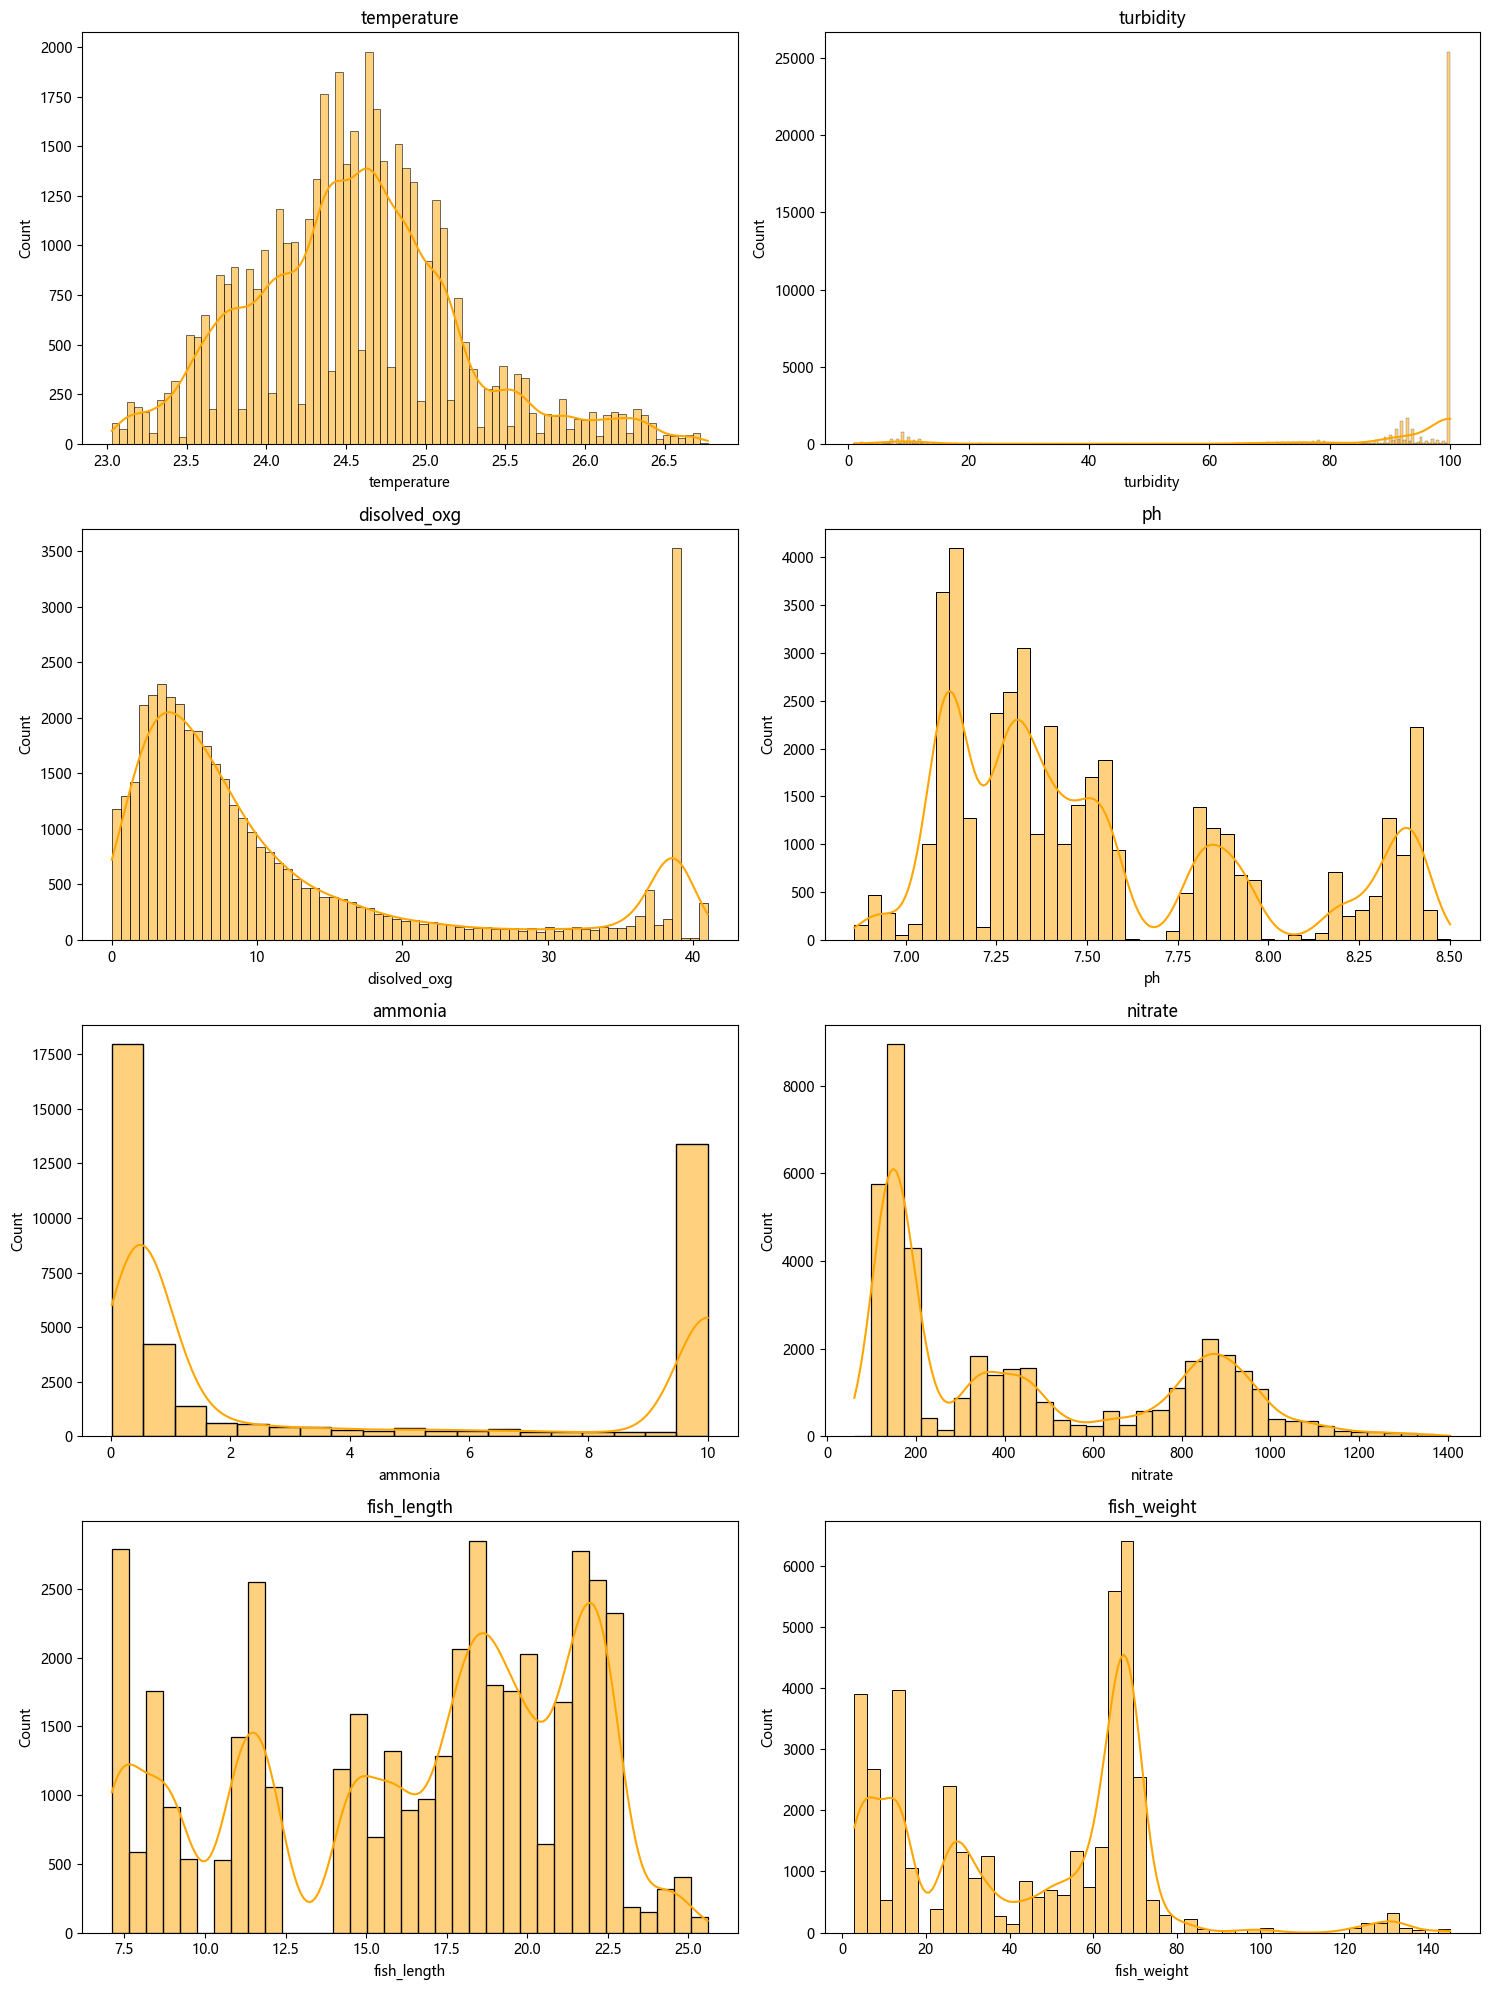

In [32]:
# 使用 分佈圖 來檢查特徵中的異常值。
visualize_distributions(df, save=True)

<ol> 直方圖（Histogram）：
    <li> 橙色部分：展示了特徵數據的分佈情況。（每個區間內的數據量） </li>
    <li> 橙色曲線：核密度估計，用於平滑數據分佈，幫助我們了解數據的大致趨勢和分佈形狀。 </li>
</ol>

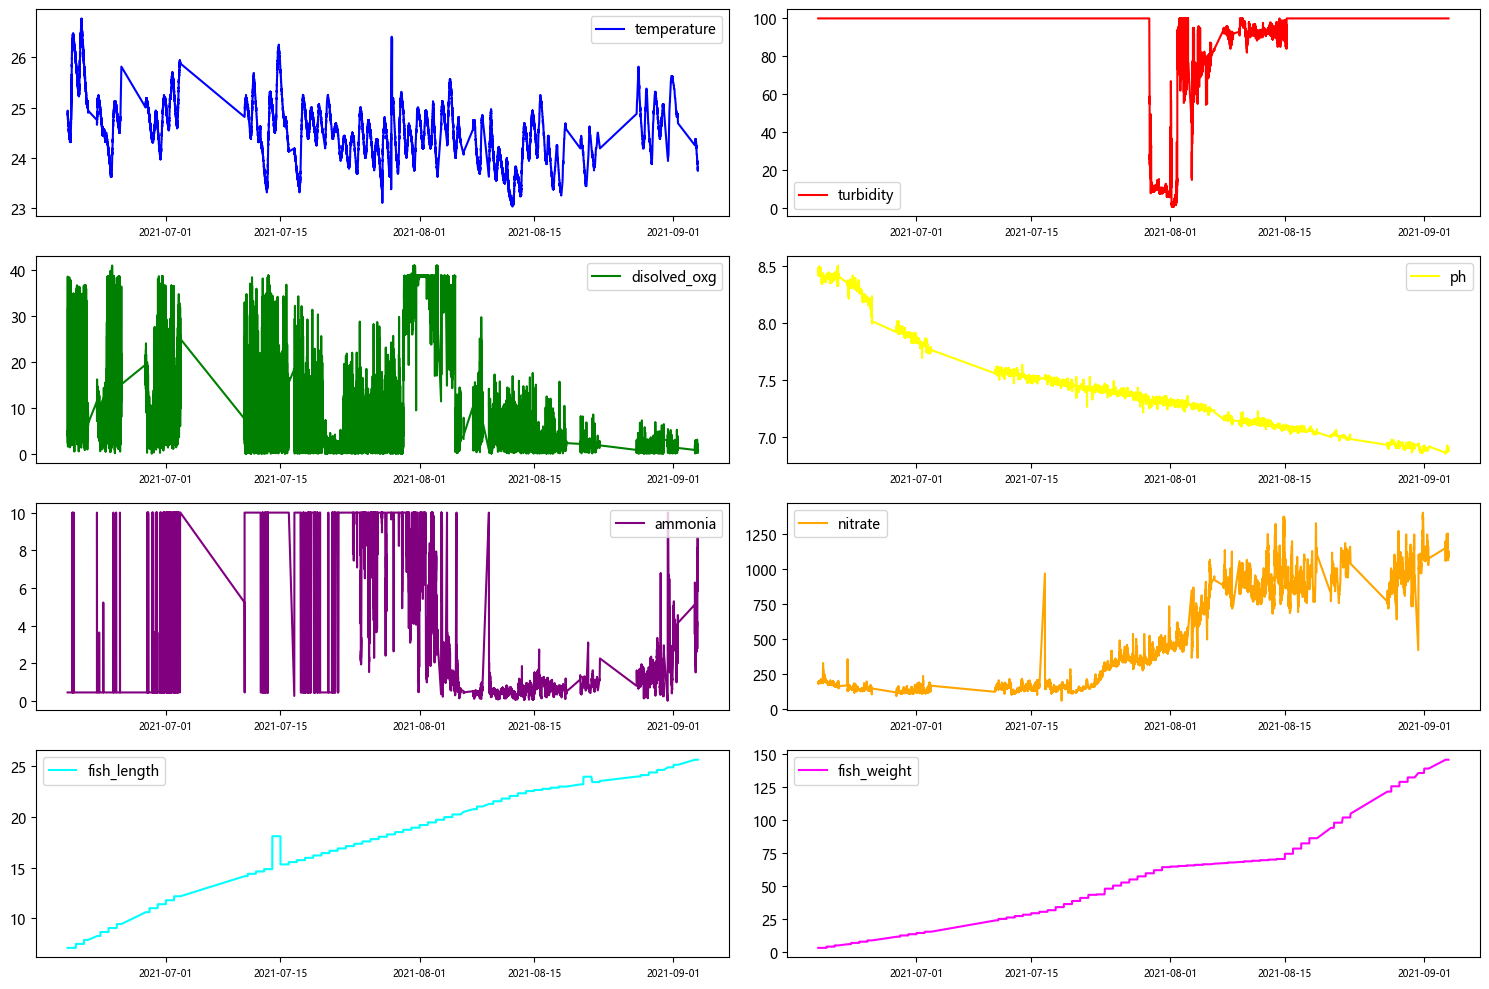

In [33]:
#visualizing a dataframe
# 將多個特徵（列）的數據繪製成子圖，並基於提供的日期時間索引進行繪製。
visualize_df(df, df.index, save=True)

<p> 針對fish_weight魚的重量特別繪製！ </p>

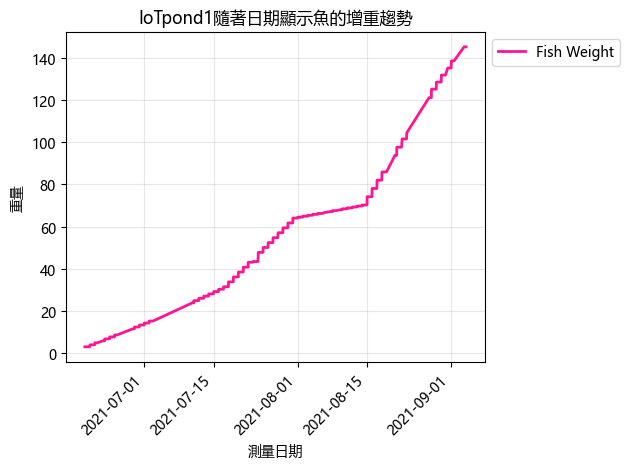

In [34]:
plt.plot(df.index, df['fish_weight'], color='deeppink', linewidth=2, label='Fish Weight')

# 设置图表标题和标签
plt.title('IoTpond1隨著日期顯示魚的增重趨勢')

# 修正 x 軸
plt.gcf().autofmt_xdate()  # 自動調整日期格式和角度
plt.xticks(rotation=45)    # 將 x 軸標籤旋轉 45 度以避免重疊
plt.xlabel('測量日期')

plt.ylabel('重量')
plt.legend(loc='best', bbox_to_anchor=(1, 1))  # Moves the legend outside the plot
plt.grid(True, alpha=0.3)  # 显示网格
plt.xticks()  # 日期标签旋转，便于阅读 #rotation=45

# 显示图形
plt.tight_layout()
plt.savefig('feature/IoTpond1 Fish Weight Growth Trend.png', bbox_inches='tight') # 儲存圖表，並且自動調整圖表的邊界，去除多餘的空白區域。
plt.show()


<h3> 證明為什麼fish_weight適合作為預測目標 </h3>

<p> Find correlations between attributes </p>

In [35]:
# using pearson's correlation to find the correlation between all the features
# population 列中的所有數值都相同，全為50，相關性無法計算，因此結果為 NaN。
df.corr()

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
temperature,1.000000,0.063871,0.142322,0.517619,0.063803,-0.434430,-0.529920,-0.462201
turbidity,0.063871,1.000000,-0.643817,0.269574,-0.242834,-0.134223,-0.268590,-0.317643
disolved_oxg,0.142322,-0.643817,1.000000,-0.010129,0.188389,-0.090093,0.004494,0.057597
ph,0.517619,0.269574,-0.010129,1.000000,-0.110590,-0.746941,-0.982158,-0.912037
ammonia,0.063803,-0.242834,0.188389,-0.110590,1.000000,-0.397191,0.012090,-0.049237
nitrate,-0.434430,-0.134223,-0.090093,-0.746941,-0.397191,1.000000,0.827923,0.843510
fish_length,-0.529920,-0.268590,0.004494,-0.982158,0.012090,0.827923,1.000000,0.948993
fish_weight,-0.462201,-0.317643,0.057597,-0.912037,-0.049237,0.843510,0.948993,1.000000


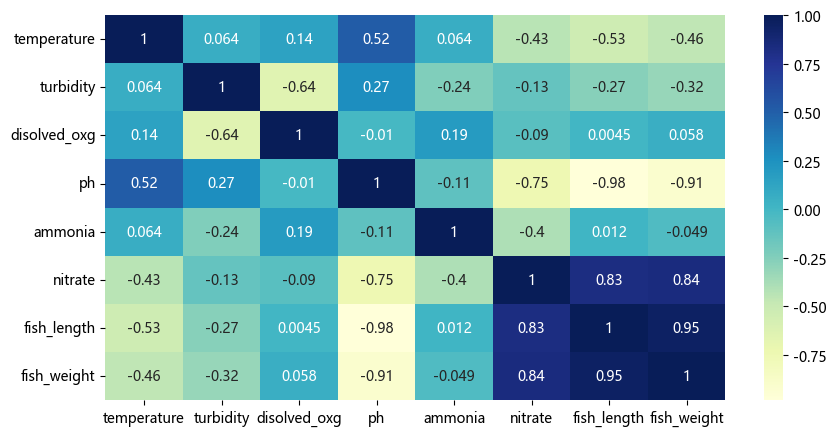

In [36]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)
plt.savefig('feature/IoTpond1 Pearson Correlation.png', bbox_inches='tight') # 儲存圖表，並且自動調整圖表的邊界，去除多餘的空白區域。
plt.show()

In [46]:
df.corr()['fish_weight']

temperature    -0.462201
turbidity      -0.317643
disolved_oxg    0.057597
ph             -0.912037
ammonia        -0.049237
nitrate         0.843510
fish_length     0.948993
fish_weight     1.000000
Name: fish_weight, dtype: float64

<p> 線性回歸、Lasso 和 Ridge 都是靜態模型，它們假設特徵與目標變數之間是靜態線性關係。 </p>
<p> 靜態回歸模型（如線性回歸、Lasso、Ridge）對於時間依賴性較差，尤其在分佈不平穩時。 </p>
<br>
<p> 而時間序列中的趨勢可能是動態的、非線性的。 </p>
<p> 當時間序列分佈改變時，這些靜態模型無法有效捕捉時間依賴性，導致性能下降。 </p>

In [37]:
def solve(X,y):

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1)
    
    # using linear regression (使用 普通線性回歸 方法對訓練數據進行建模。)
    # 找到一條直線，使得該直線可以最好地解釋特徵與目標值之間的線性關係。
    model = LinearRegression()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("R2_score of Linear Regression:",r2_score(y_test,y_pred))

    # using Lasso regression (L1 正則化項)
    # Lasso 回歸會對不重要的特徵執行特徵選擇（即將某些權重變為 0），以減少過擬合。
    # 自動選擇重要特徵，並且能有效處理高維數據，提升模型的可解釋性。
    model = Lasso(alpha=0.1)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("R2_score of Lasso Regression:",r2_score(y_test,y_pred))

    # using Ridge regression ( L2 正則化項)
    # Ridge 回歸會對所有權重施加懲罰，但不會將它們變為 0，適合處理多重共線性問題。
    model = Ridge(alpha=0.1)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("R2_score of Ridge Regression:",r2_score(y_test,y_pred))

In [38]:
X = df[ ['temperature', 'turbidity', 'disolved_oxg', 'ph', 'ammonia', 'nitrate', 'fish_length'] ]
y = df['fish_weight']

In [39]:
# R² 分數（決定係數，Coefficient of Determination）是一個評估回歸模型性能的指標，用於衡量模型對於數據變異的解釋能力。
# R²=1：模型完美解釋數據。
# R²=0：模型與目標值沒有關係。
# R²<0：模型比隨機猜測更糟糕。
solve(X,y)

R2_score of Linear Regression: 0.9209967249739073
R2_score of Lasso Regression: 0.9186337024420631
R2_score of Ridge Regression: 0.9209966006884496


<p> Reference: How to approach a dataset (EDA)- Learn With Me 如何使用資料集 （EDA）  </p>
https://www.kaggle.com/code/prakharjadaun/how-to-approach-a-dataset-eda-learn-with-me

<h3> Normalize (min-max-scaler) </h3>
<ol> Note:為什麼使用min-max-scaler
    <li> 保留數據分佈的形狀。 </li>
    <li> Fish Weight是遞增型數據，推薦使用MinMaxScaler。 </li>
    <li> 模型是LSTM，使用MinMaxScaler，將數據縮放到[0, 1] 範圍內，助於加快模型收斂速度。。 </li>
</ol>

In [40]:
normalizer = MinMaxScaler() # 將數據縮放到一個固定範圍內（例如 [0, 1]）。
df[df.columns.tolist()] = normalizer.fit_transform(df[df.columns.tolist()]) # 第一步：正規化數據
df

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
created_at,,,,,,,,
2021-06-19 00:00:00,0.493036,1.0,0.109723,0.958565,0.044254,0.098141,0.0,0.0
2021-06-19 00:01:00,0.504178,1.0,0.223008,0.957642,0.044254,0.098141,0.0,0.0
2021-06-19 00:02:00,0.504178,1.0,0.366606,0.951195,0.044254,0.098141,0.0,0.0
2021-06-19 00:03:00,0.504178,1.0,0.202586,0.956723,0.044254,0.097646,0.0,0.0
2021-06-19 00:04:00,0.493036,1.0,0.169721,0.988949,0.044254,0.096654,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-09-03 23:36:00,0.192201,1.0,0.013956,0.022102,0.668428,0.782900,1.0,1.0
2021-09-03 23:43:00,0.192201,1.0,0.019617,0.019339,0.581870,0.795539,1.0,1.0
2021-09-03 23:45:00,0.208914,1.0,0.050750,0.016577,0.719451,0.775465,1.0,1.0


<p> save dataset </p>

In [41]:
y = df['fish_weight'].values
pd.DataFrame(y, columns=['fish_weight'], index=df.index)

,fish_weight
created_at,
2021-06-19 00:00:00,0.0
2021-06-19 00:01:00,0.0
2021-06-19 00:02:00,0.0
2021-06-19 00:03:00,0.0
2021-06-19 00:04:00,0.0
...,...
2021-09-03 23:36:00,1.0
2021-09-03 23:43:00,1.0
2021-09-03 23:45:00,1.0


In [42]:
X = df.drop(['fish_weight'], axis=1).values
pd.DataFrame(X, columns=df.columns[:-1], index=df.index)

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length
created_at,,,,,,,
2021-06-19 00:00:00,0.493036,1.0,0.109723,0.958565,0.044254,0.098141,0.0
2021-06-19 00:01:00,0.504178,1.0,0.223008,0.957642,0.044254,0.098141,0.0
2021-06-19 00:02:00,0.504178,1.0,0.366606,0.951195,0.044254,0.098141,0.0
2021-06-19 00:03:00,0.504178,1.0,0.202586,0.956723,0.044254,0.097646,0.0
2021-06-19 00:04:00,0.493036,1.0,0.169721,0.988949,0.044254,0.096654,0.0
...,...,...,...,...,...,...,...
2021-09-03 23:36:00,0.192201,1.0,0.013956,0.022102,0.668428,0.782900,1.0
2021-09-03 23:43:00,0.192201,1.0,0.019617,0.019339,0.581870,0.795539,1.0
2021-09-03 23:45:00,0.208914,1.0,0.050750,0.016577,0.719451,0.775465,1.0


In [43]:
# 取前面80%為train，後面20%為test。
data_dic = {'X_train':X[:int(X.shape[0]*0.2)],
            'y_train':y[:int(X.shape[0]*0.2)],
            'X_test':X[int(y.shape[0]*0.2):],
            'y_test':y[int(y.shape[0]*0.2):]}

data_dic

{'X_train': array([[0.49303621, 1.        , 0.10972307, ..., 0.04425355, 0.09814126,
         0.        ],
        [0.50417827, 1.        , 0.22300842, ..., 0.04425355, 0.09814126,
         0.        ],
        [0.50417827, 1.        , 0.36660567, ..., 0.04425355, 0.09814126,
         0.        ],
        ...,
        [0.49303621, 1.        , 0.15268188, ..., 1.        , 0.05724907,
         0.21092482],
        [0.49860724, 1.        , 0.14511813, ..., 1.        , 0.05848823,
         0.21092482],
        [0.49303621, 1.        , 0.1341873 , ..., 1.        , 0.05675341,
         0.21092482]]),
 'y_train': array([0.        , 0.        , 0.        , ..., 0.06601587, 0.06601587,
        0.06601587]),
 'X_test': array([[0.49303621, 1.        , 0.14972144, ..., 1.        , 0.06121437,
         0.21092482],
        [0.48746518, 1.        , 0.18305884, ..., 1.        , 0.0574969 ,
         0.21092482],
        [0.49303621, 1.        , 0.12311821, ..., 0.68141785, 0.05675341,
         0.21092

In [44]:
# 儲存為pkl檔案
# pkl檔案 用於儲存 Python 資料結構。
for key,value in data_dic.items():
    with open(f'{key}.pkl','wb') as f: # 使用 pickle.dump 將數據寫入文件，'wb' 表示二進制寫入。
        pickle.dump(value, f)

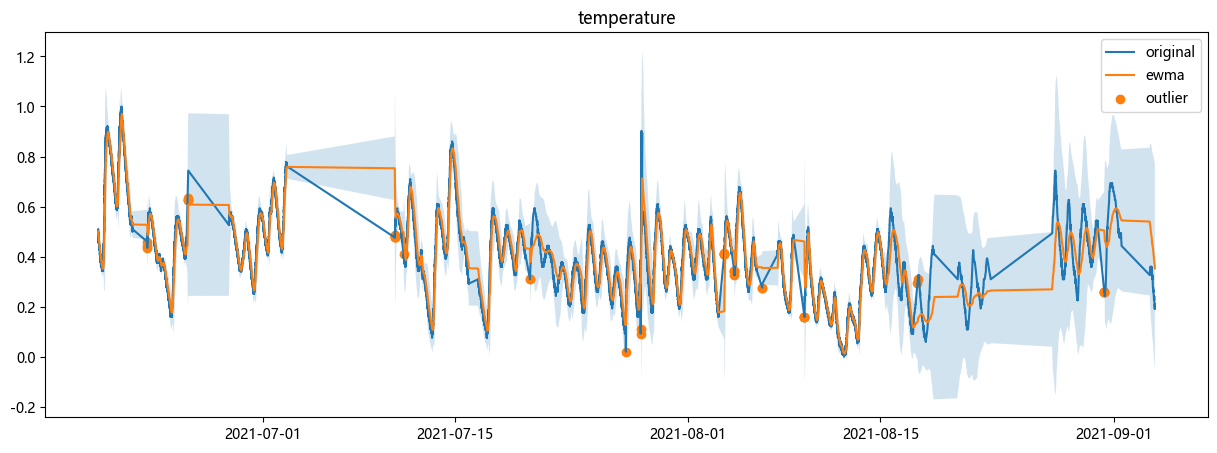

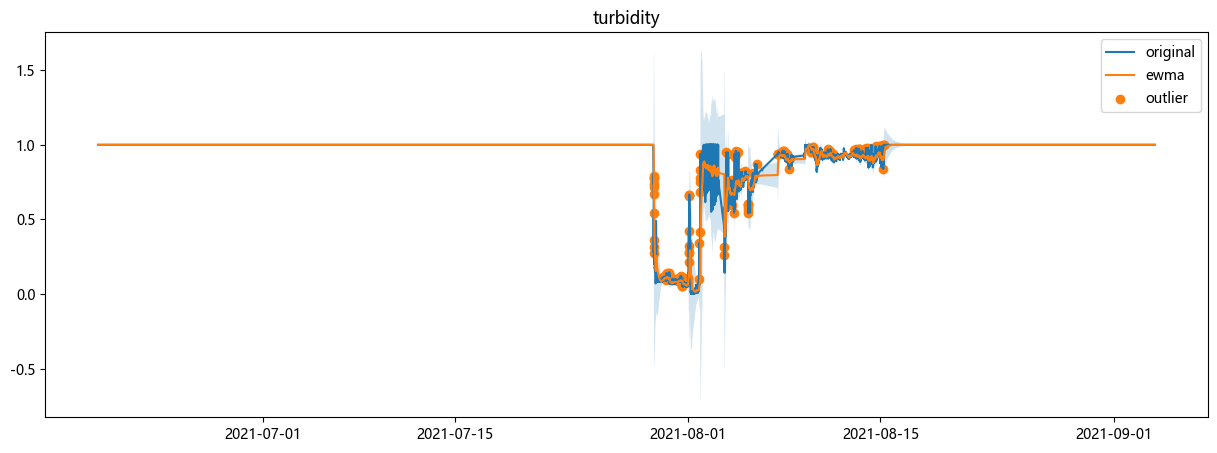

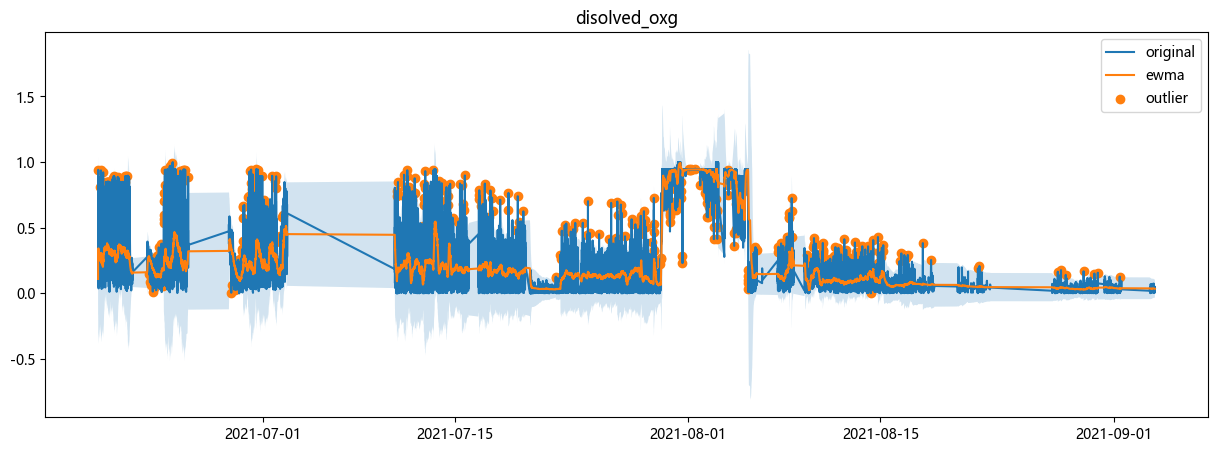

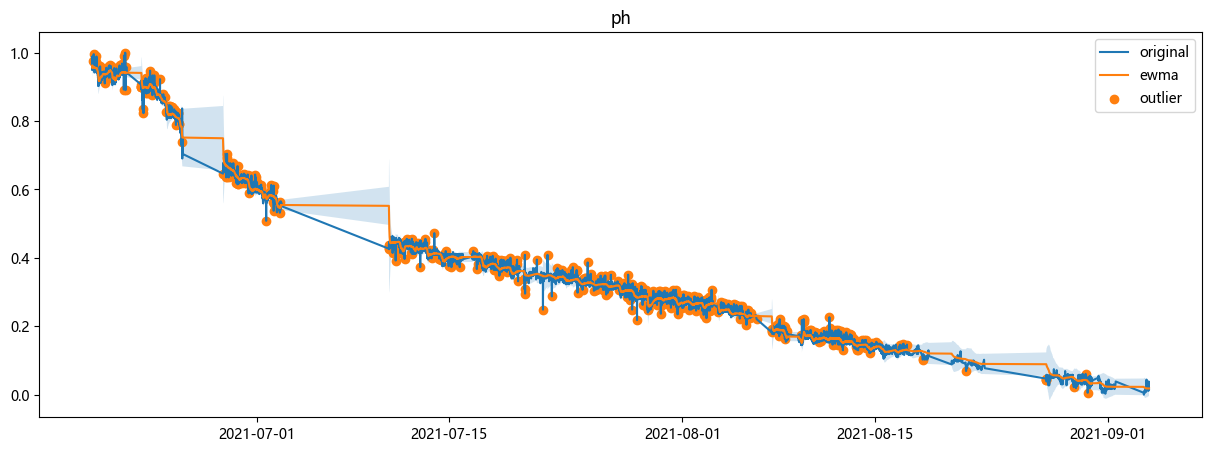

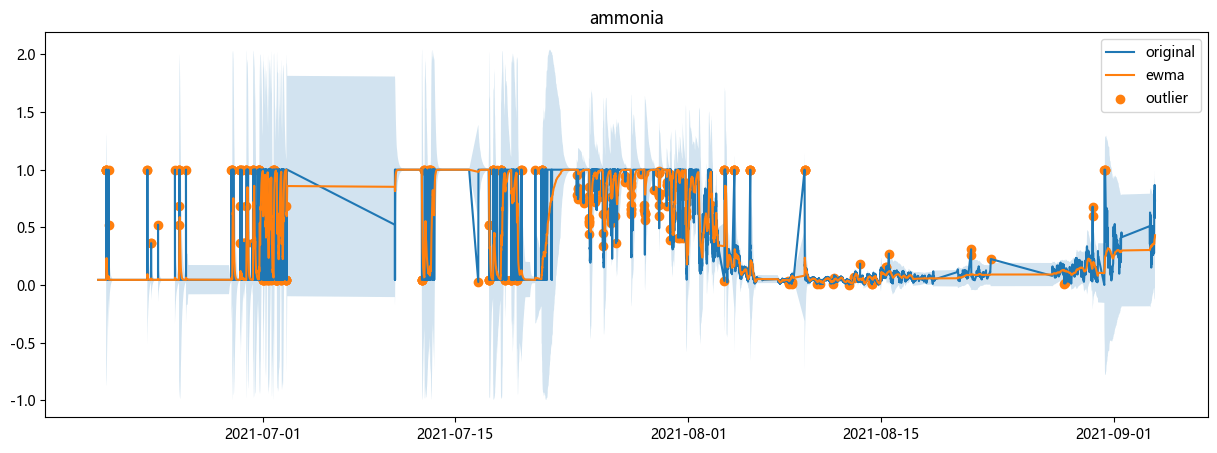

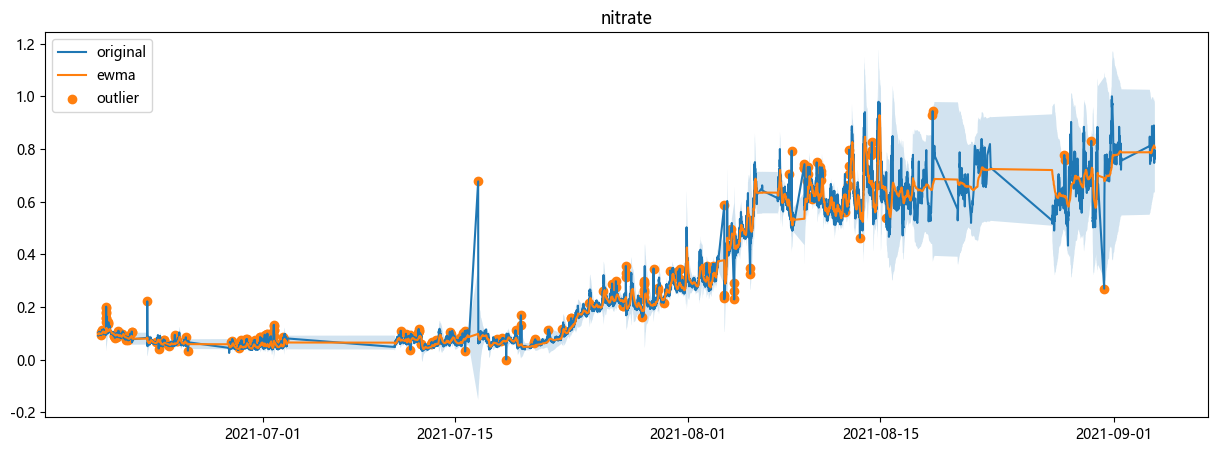

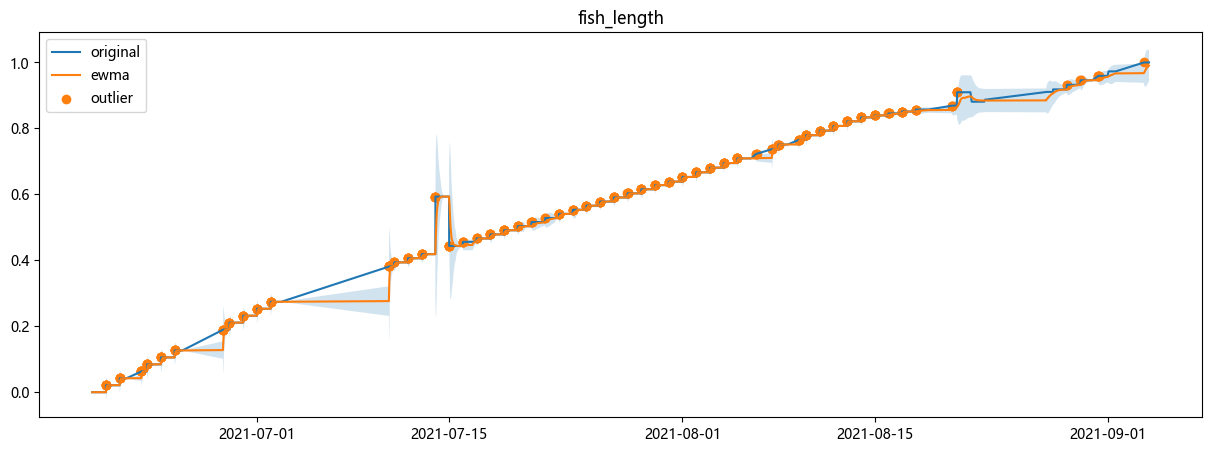

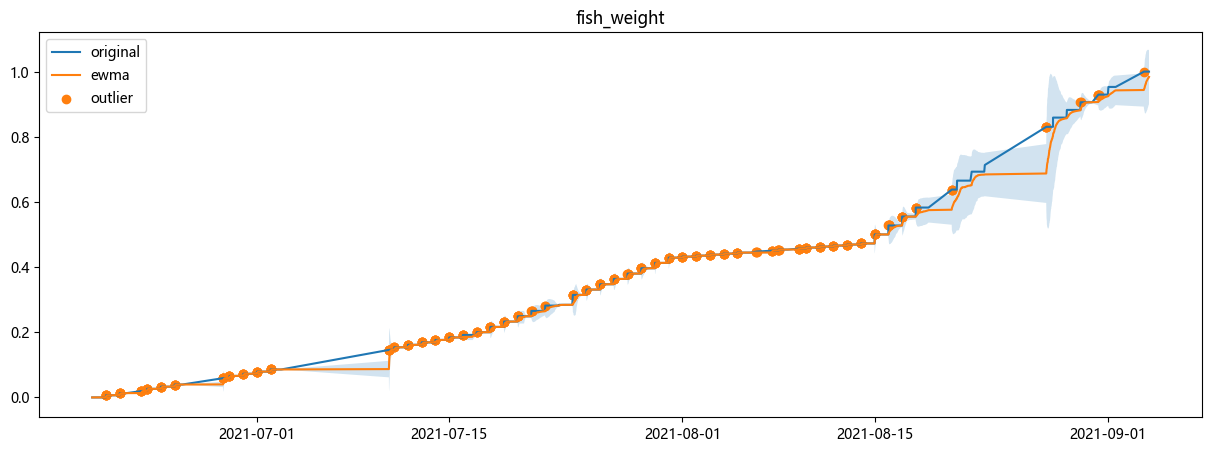

In [45]:
# save feature plot 
for n_column in df.columns:
    plot_outlier(df[n_column], n_column, save=True)

<p> Reference: Aquaponics Dataset Forecasting: Model Comparison </p>
https://www.kaggle.com/code/hocheping/aquaponics-dataset-forecasting-model-comparison/edit

<p> Reference:Aquaponics-Fish-Pond-Datasets-Forecasting-Model</p>
https://www.kaggle.com/code/hocheping/aquaponics-fish-pond-datasets-forecasting-model/edit